In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_chunks(text, tokenizer, max_tokens=450, overlap_tokens=60):
    """
    Greedy pack sentences into chunks under max_tokens using the model tokenizer.
    Adds a small sentence-level overlap between adjacent chunks using tokens.
    """
    sents = sent_tokenize(text)
    chunks = []
    current = []
    current_tokens = 0

    def tok_len(t):
        return len(tokenizer.tokenize(t))

    i = 0
    while i < len(sents):
        s = sents[i]
        s_tokens = tok_len(s)
        if s_tokens > max_tokens:
            # Very long sentence: hard split by words as a rare fallback
            words = s.split()
            # keep ~max_tokens-10 tokens margin when splitting
            step = max(1, int(len(words) * (max_tokens / (s_tokens + 1e-9))))
            for wstart in range(0, len(words), step):
                piece = " ".join(words[wstart:wstart+step])
                chunks.append(piece)
            i += 1
            current, current_tokens = [], 0
            continue

        if current_tokens + s_tokens <= max_tokens:
            current.append(s)
            current_tokens += s_tokens
            i += 1
        else:
            # finalize current chunk
            if current:
                chunk_text = " ".join(current)
                chunks.append(chunk_text)

                # build overlap buffer from the end of current
                if overlap_tokens > 0:
                    back = []
                    back_tokens = 0
                    for sent in reversed(current):
                        tl = tok_len(sent)
                        if back_tokens + tl > overlap_tokens:
                            break
                        back.append(sent)
                        back_tokens += tl
                    current = list(reversed(back))
                    current_tokens = sum(tok_len(x) for x in current)
                else:
                    current, current_tokens = [], 0
            else:
                # edge case: single sentence larger than budget handled above
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
tokenizer = model.tokenizer

W0819 22:59:56.580000 62452 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


README.md: 0.00B [00:00, ?B/s]

In [5]:
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    for i, chunk in enumerate(sentence_chunks(chap_text, tokenizer,
                                              max_tokens=450, overlap_tokens=60), start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "text": chunk
        })

In [6]:
print(f"Total chunks created: {len(all_chunks)}")
print(f"Example chunk: {all_chunks[50]}")

Total chunks created: 369
Example chunk: {'chapter': 5, 'chunk_id': '5_1', 'text': '\n My nagging got the better of Jem eventually, as I knew it would, and to my relief \nwe slowed down the game for a while. He still maintained, however, that Atticus \nhadn’t said we couldn’t, therefore we could; and if Atticus ever said we couldn’t, \nJem had thought of a way around it: he would simply change the names of the \ncharacters and then we couldn’t be accused of playing anything. Dill was in hearty agreement with this plan of action. Dill was becoming \nsomething of a trial anyway, following Jem about. He had asked me earlier in the \nsummer to marry him, then he promptly forgot about it. He staked me out, marked \nas his property, said I was the only girl he would ever love, then he neglected me. I beat him up twice but it did no good, he only grew closer to Jem. They spent \ndays together in the treehouse plotting and planning, calling me only when they \nneeded a third party. But I kept 

In [7]:
texts = [chunk['text'] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_tensor=False, show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
embeddings[1]  # Example to show the embedding of the second chunk

array([-2.57084407e-02,  6.11791164e-02,  1.40771829e-03,  1.75060723e-05,
       -3.98007333e-02,  1.92359816e-02, -1.53717324e-02, -8.10483098e-03,
        1.40671153e-02, -2.97832191e-02,  8.98269285e-03,  7.66535178e-02,
        6.14860393e-02, -5.38585596e-02, -2.29360051e-02,  4.69067059e-02,
       -2.75505371e-02,  4.83390950e-02,  3.67982350e-02,  1.01526929e-02,
       -2.65493859e-02,  4.19890098e-02,  2.33274307e-02, -2.60379110e-02,
        2.98224483e-02, -7.44916219e-03,  8.91691260e-03,  3.84011082e-02,
       -4.92018536e-02, -1.33131891e-02, -7.92668760e-03,  8.66289530e-03,
       -1.41528379e-02, -3.42739448e-02,  2.10065696e-06,  1.27481902e-02,
        2.46044155e-02, -2.07386054e-02, -2.75453031e-02,  3.72424237e-02,
        6.75441101e-02,  2.17401795e-02,  1.97675619e-02,  1.94610003e-02,
       -5.75919561e-02,  9.86258406e-03, -5.01122251e-02,  1.19426530e-02,
       -2.92861033e-02,  8.20831489e-03,  6.88517559e-03,  1.28594544e-02,
        2.61526760e-02,  

In [9]:
embeddings.shape

(369, 768)

Indexing with FAISS (Facebook AI Similarity Search)

In [10]:
import faiss
import numpy as np

# Convert to float32 ( required for FAISS)
embedding_matrix = np.array(embeddings).astype('float32')

# Build index (using cosine)
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product = Cosine similarity (after normalization)

# Normalize for cosine similarity
faiss.normalize_L2(embedding_matrix)

# Add vectors
index.add(embedding_matrix)

In [11]:
def search_faiss(query, top_k=5):
    # Encode and normalize query
    query_vec = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(query_vec)

    # Search index
    scores, indices = index.search(query_vec, top_k)

    # Retrieve the corresponding chunks
    results = []
    for i, score in zip(indices[0], scores[0]):
        result = {
            "chunk_id": all_chunks[i]["chunk_id"],
            "chapter": all_chunks[i]["chapter"],
            "text": all_chunks[i]["text"],
            "score": float(score)
        }
        results.append(result)
    
    return results


LLM to Q uery

In [13]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book/novel style and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [14]:
generated_text = generate_text("In the novel 'To Kill a Mockingbird' what was happening to Jem?")
print(generated_text)

In Harper Lee’s novel *To Kill a Mockingbird*, Jem Finch experiences a significant and poignant transformation throughout the story, both emotionally and physically. As the novel progresses, Jem is moving from childhood innocence into a more mature understanding of the complexities and injustices of the world around him. 

Specifically, by the later parts of the novel, Jem is struggling with the harsh realities following the trial of Tom Robinson. He is grappling with the unfair verdict and the ingrained racism he witnesses in Maycomb, which deeply affects his sense of justice and morality. This internal conflict causes Jem to become more serious and introspective. Physically, he is also growing up—he is older and stronger than Scout, and his changing body mirrors the changes in his perceptions and attitude.

Additionally, after the attack by Bob Ewell near the end of the novel, Jem is injured and unconscious for a time, which symbolizes the physical and emotional toll that the town’s 

In [15]:
query = generated_text
top_results = search_faiss(query, top_k=10)

for res in top_results:
    print(f"Chapter {res['chapter']} | Chunk {res['chunk_id']} | Score: {res['score']:.3f}")
    print(res['text'])
    print("---")


Chapter 12 | Chunk 12_1 | Score: 0.712

 Jem was twelve. He was difficult to live with, inconsistent, moody. His appetite 
was appalling, and he told me so many times to stop pestering him I consulted 
Atticus: “Reckon he’s got a tapeworm?” Atticus said no, Jem was growing. I must 
be patient with him and disturb him as little as possible. This change in Jem had come about in a matter of weeks. Mrs. Dubose was not 
cold in her grave—Jem had seemed grateful enough for my company when he 
went to read to her. Overnight, it seemed, Jem had acquired an alien set of values 
and was trying to impose them on me: several times he went so far as to tell me 
what to do. After one altercation when Jem hollered, “It’s time you started bein‘ a 
girl and acting right!” I burst into tears and fled to Calpurnia. “Don’t you fret too much over Mister Jem—” she began. “Mister Jem?”
 “Yeah, he’s just about Mister Jem now.”
 “He ain’t that old,” I said. “All he needs is somebody to beat him up, and I ain’t

Evaluation before Re-Ranking

In [ ]:
#calculate precision at k
def calculate_precision_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / k if k > 0 else 0.0

#calculate recall at k
def calculate_recall_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / len(relevant_set) if relevant_set else 0.0

#calculate f1 score at k
def calculate_f1_at_k(retrieved, relevant, k):
    precision = calculate_precision_at_k(retrieved, relevant, k)
    recall = calculate_recall_at_k(retrieved, relevant, k)
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0.0

#calculate MRR
def calculate_mrr(retrieved, relevant):
    mrr = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            mrr = 1 / (i + 1)
            break
    return mrr

#Calculate nDCG
def calculate_ndcg(retrieved, relevant):
    dcg = 0.0
    idcg = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            dcg += 1 / (np.log2(i + 2))
    for i, doc in enumerate(relevant):
        idcg += 1 / (np.log2(i + 2))
    return dcg / idcg if idcg > 0 else 0.0

#calculate accuracy
def calculate_accuracy(retrieved, relevant):
    relevant_set = set(relevant)
    num_correct = sum(1 for doc in retrieved if doc in relevant_set)
    return num_correct / len(relevant_set) if relevant_set else 0.0

relevant_docs = {"7_1", "9_18", "12_1", "28_15","10_1"}  # relevant doc ids for a single query
retrieved_docs = [r["chunk_id"] for r in top_results]  # retrieved doc ids from the search results
print("Precision at k:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=10))
print("Recall at k:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=10))
print("F1 at k:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=10))
print("MRR:", calculate_mrr(retrieved_docs, relevant_docs))
print("nDCG:", calculate_ndcg(retrieved_docs, relevant_docs))
print("Accuracy:", calculate_accuracy(retrieved_docs, relevant_docs))

Precision at k: 0.4
Recall at k: 0.8
F1 at k: 0.5333333333333333
MRR: 1.0
nDCG: 0.7860137352654724
Accuracy: 0.8


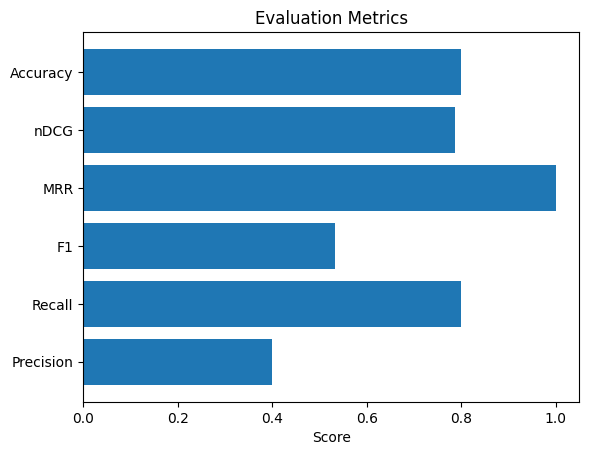

In [27]:
#plot the results
import matplotlib.pyplot as plt

metrics = {
    "Precision": calculate_precision_at_k(retrieved_docs, relevant_docs, k=10),
    "Recall": calculate_recall_at_k(retrieved_docs, relevant_docs, k=10),
    "F1": calculate_f1_at_k(retrieved_docs, relevant_docs, k=10),
    "MRR": calculate_mrr(retrieved_docs, relevant_docs),
    "nDCG": calculate_ndcg(retrieved_docs, relevant_docs),
    "Accuracy": calculate_accuracy(retrieved_docs, relevant_docs)
}

plt.barh(list(metrics.keys()), list(metrics.values()))
plt.xlabel("Score")
plt.title("Evaluation Metrics")
plt.show()


Reranking With A Cross Encoder

In [16]:
from sentence_transformers import CrossEncoder
_reranker = None

def get_reranker():
    global _reranker
    if _reranker is None:
        _reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    return _reranker

In [21]:
# FAISS -> Cross-Encoder re-ranking
# topN: how many candidates to pull from FAISS before re-ranking
# final_topk: how many to return after re-ranking

from collections import defaultdict

def search_faiss_rerank(query, topN=50, final_topk=10, group_by_chapter=True, per_chapter=3, batch_size=32):
    # 1) Retrieve candidates with FAISS
    import faiss
    q = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q)
    scores, idxs = index.search(q, topN)

    candidates = []
    for j, i in enumerate(idxs[0]):
        candidates.append({
            "chunk_id": all_chunks[i]["chunk_id"],
            "chapter": all_chunks[i]["chapter"],
            "text": all_chunks[i]["text"],
            "retrieval_score": float(scores[0][j]),
            "_idx": int(i)
        })

    if not candidates:
        return []
      # 2) Re-rank with cross-encoder
    ce = get_reranker()
    pairs = [(query, c["text"]) for c in candidates]
    ce_scores = ce.predict(pairs, batch_size=batch_size)
    for c, s in zip(candidates, ce_scores):
        c["ce_score"] = float(s)

    # 3) Sort by CE score and slice
    candidates.sort(key=lambda x: x["ce_score"], reverse=True)
    top = candidates[:final_topk]

    if not group_by_chapter:
        return top

    # 4) chapter-aware grouping
    buckets = defaultdict(list)
    
    for c in top:
        buckets[c["chapter"]].append(c)

    cards = []
    for chap, items in buckets.items():
        items.sort(key=lambda x: x["ce_score"], reverse=True)
        chapter_score = max(i["ce_score"] for i in items)
        cards.append({
            "chapter": chap,
            "chapter_score": chapter_score,
            "chunks": items[:per_chapter]
        })

    cards.sort(key=lambda x: x["chapter_score"], reverse=True)
    return cards


In [22]:
Rerank_results = search_faiss_rerank(generated_text, topN=100, final_topk=10, group_by_chapter=True, per_chapter=3, batch_size=32)

In [66]:
Rerank_results

[{'chapter': 7,
  'chapter_score': 0.0435725562274456,
  'chunks': [{'chunk_id': '7_6',
    'chapter': 7,
    'text': 'I bet it’s Miss Maudie—been bettin‘ that for a \nlong time.”\n “Ar-r, Miss Maudie can’t chew gum—” Jem broke into a grin. “You know, she \ncan talk real pretty sometimes. One time I asked her to have a chew and she said \nno thanks, that—chewing gum cleaved to her palate and rendered her speechless,” \nsaid Jem carefully. “Doesn’t that sound nice?”\n “Yeah, she can say nice things sometimes. She wouldn’t have a watch and chain \nanyway.”\n “Dear sir,” said Jem. “We appreciate the—no, we appreciate everything which \nyou have put into the tree for us. Yours very truly, Jeremy Atticus Finch.”\n “He won’t know who you are if you sign it like that, Jem.”\n Jem erased his name and wrote, “Jem Finch.” I signed, “Jean Louise Finch \n(Scout),” beneath it. Jem put the note in an envelope. Next morning on the way to school he ran ahead of me and stopped at the tree. Jem was faci

Evaluation

# ===== Metrics: binary relevance (chapter-level) =====
import math
from typing import Dict, List, Set, Iterable

def precision_at_k(ranked_items: Iterable, relevant: Set, k: int) -> float:
    ranked = list(ranked_items)[:k]
    if k == 0: return 0.0
    return sum(1 for x in ranked if x in relevant) / k

def recall_at_k(ranked_items: Iterable, relevant: Set, k: int) -> float:
    if not relevant: return 0.0
    ranked = list(ranked_items)[:k]
    hits = sum(1 for x in ranked if x in relevant)
    return hits / len(relevant)

def average_precision(ranked_items: Iterable, relevant: Set, k: int = None) -> float:
    ranked = list(ranked_items)
    if k is not None:
        ranked = ranked[:k]
    if not relevant:
        return 0.0
    ap, hits = 0.0, 0
    for i, x in enumerate(ranked, start=1):
        if x in relevant:
            hits += 1
            ap += hits / i
    return ap / max(1, len(relevant))

def mean_average_precision(all_ranked: Dict[str, List], gold: Dict[str, Set], k: int = None) -> float:
    if not all_ranked: return 0.0
    aps = []
    for qid, ranked in all_ranked.items():
        aps.append(average_precision(ranked, gold.get(qid, set()), k))
    return sum(aps) / len(aps)

def mrr(all_ranked: Dict[str, List], gold: Dict[str, Set], k: int = None) -> float:
    if not all_ranked: return 0.0
    total = 0.0
    for qid, ranked in all_ranked.items():
        r = list(ranked)
        if k is not None:
            r = r[:k]
        rr = 0.0
        for i, x in enumerate(r, start=1):
            if x in gold.get(qid, set()):
                rr = 1.0 / i
                break
        total += rr
    return total / len(all_ranked)

def dcg_at_k(ranked_items: Iterable, gains: Dict, k: int) -> float:
    dcg = 0.0
    for i, x in enumerate(list(ranked_items)[:k], start=1):
        rel = gains.get(x, 0)
        if rel > 0:
            dcg += (2**rel - 1) / math.log2(i + 1)
    return dcg

def ndcg_at_k(ranked_items: Iterable, gains: Dict, k: int) -> float:
    dcg = dcg_at_k(ranked_items, gains, k)
    # Ideal ordering (sort by gain desc)
    ideal = [x for x, _ in sorted(gains.items(), key=lambda kv: kv[1], reverse=True)]
    idcg = dcg_at_k(ideal, gains, k)
    return 0.0 if idcg == 0 else dcg / idcg

def hit_at_k(ranked_items: Iterable, relevant: Set, k: int) -> float:
    ranked = list(ranked_items)[:k]
    return 1.0 if any(x in relevant for x in ranked) else 0.0  # Accuracy@k in IR parlance


from typing import Dict, List

def rank_chapters_from_cards(cards_by_qid: Dict[str, List[dict]],
                             mode: str = "ce_max") -> Dict[str, List]:
    """
    mode:
      - 'ce_max'  : sort chapters by max ce_score among its chunks  (USES RERANKER)
      - 'ce_mean' : sort by mean ce_score among its chunks          (USES RERANKER)
      - 'card'    : sort by card['chapter_score'] (assumes it's CE-based)
      - 'retrieval_max' : fallback using max retrieval_score
    """
    out = {}
    for qid, cards in cards_by_qid.items():
        def score_card(card):
            chunks = card.get("chunks", [])
            if mode == "ce_max":
                return max((c.get("ce_score", float("-inf")) for c in chunks), default=card.get("chapter_score", 0.0))
            elif mode == "ce_mean":
                vals = [c.get("ce_score", None) for c in chunks if "ce_score" in c]
                return sum(vals)/len(vals) if vals else card.get("chapter_score", 0.0)
            elif mode == "retrieval_max":
                return max((c.get("retrieval_score", float("-inf")) for c in chunks), default=card.get("chapter_score", 0.0))
            else:  # 'card'
                return card.get("chapter_score", 0.0)

        ranked = sorted(cards, key=score_card, reverse=True)
        out[qid] = [c["chapter"] for c in ranked]
    return out


from collections import defaultdict
from typing import Dict, List

def rank_chapters_from_chunks(results_by_qid: Dict[str, List[dict]],
                              score_key: str = "ce_score",
                              agg: str = "max") -> Dict[str, List]:
    """
    Group chunks by chapter, aggregate CE or retrieval scores, then rank chapters.
    agg: 'max' or 'mean'
    """
    out = {}
    for qid, items in results_by_qid.items():
        bucket = defaultdict(list)
        for it in items:
            bucket[it["chapter"]].append(float(it.get(score_key, 0.0)))

        scored = []
        for chap, vals in bucket.items():
            if agg == "mean":
                s = sum(vals)/len(vals)
            else:
                s = max(vals)
            scored.append((chap, s))
        scored.sort(key=lambda x: x[1], reverse=True)
        out[qid] = [chap for chap, _ in scored]
    return out


cards = search_faiss_rerank(query, topN=100, final_topk=10, group_by_chapter=True)


ranked_chapters = rank_chapters_from_cards({"q1": cards}, mode="ce_max")["q1"]
len(ranked_chapters)

def evaluate_after_rerank(
    queries: Dict[str, str],                 # {qid: query_text}
    gold_chapters: Dict[str, Set],           # {qid: set([chapter_ids])}
    topN: int = 100,
    final_topk: int = 10,
    ks: Iterable[int] = (1, 3, 5, 10),
    per_chapter: int = 3,
    batch_size: int = 32
):
    # Run retrieval+rERANK (grouped by chapter)
    cards_by_qid = {}
    for qid, qtext in queries.items():
        cards = search_faiss_rerank(
            qtext,
            topN=topN,
            final_topk=final_topk,
            group_by_chapter=True,
            per_chapter=per_chapter,
            batch_size=batch_size
        )
        cards_by_qid[qid] = cards

    # Build ranked chapter lists
    ranked_chapters = rank_chapters_from_cards(cards_by_qid)

    # Compute metrics
    report = {
        "Hit@k": {},
        "Precision@k": {},
        "Recall@k": {},
        "MAP@k": {},
        "MRR@k": {},
        "nDCG@k": {}
    }

    # For nDCG, we’ll use binary gains (1 for relevant chapters)
    gains_by_qid = {qid: {chap: (1 if chap in gold_chapters.get(qid, set()) else 0)
                          for chap in ranked_chapters.get(qid, [])}
                    for qid in ranked_chapters}

    num_q = max(1, len(ranked_chapters))

    for k in ks:
        # Averages across queries
        hit = sum(hit_at_k(ranked_chapters[qid], gold_chapters.get(qid, set()), k)
                  for qid in ranked_chapters) / num_q

        prec = sum(precision_at_k(ranked_chapters[qid], gold_chapters.get(qid, set()), k)
                   for qid in ranked_chapters) / num_q

        rec = sum(recall_at_k(ranked_chapters[qid], gold_chapters.get(qid, set()), k)
                  for qid in ranked_chapters) / num_q

        mapk = mean_average_precision(ranked_chapters, gold_chapters, k)
        mrrk = mrr(ranked_chapters, gold_chapters, k)

        ndcg = sum(ndcg_at_k(ranked_chapters[qid], gains_by_qid.get(qid, {}), k)
                   for qid in ranked_chapters) / num_q

        report["Hit@k"][k] = hit
        report["Precision@k"][k] = prec
        report["Recall@k"][k] = rec
        report["MAP@k"][k] = mapk
        report["MRR@k"][k] = mrrk
        report["nDCG@k"][k] = ndcg

    return report, cards_by_qid, ranked_chapters


# Example query set
queries = {
    "q1": "In the novel 'To Kill a Mockingbird' what was happening to Jem?",
    #"q2": "Describe the courthouse scene during the trial.",
    # ...
}

# Gold chapters (binary relevance per query)
gold_chapters = {
    "q1": {7, 9, 12, 28, 10},       # e.g., Chapter 31 is where the realization lands 7_1", "9_18", "12_1", "28_15","10_1"
    #"q2": {17, 18},   # multiple acceptable chapters if relevant
    # ...
}

report, cards_by_qid, ranked_chapters = evaluate_after_rerank(
    queries,
    gold_chapters,
    topN=50,
    final_topk=10,
    ks=(1,3,5,10),
    per_chapter=3,
    batch_size=32
)

print("Evaluation (chapter-level, after rerank):")
for metric, vals in report.items():
    print(metric, {k: round(v, 4) for k, v in vals.items()})
